In [1]:
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import urllib
import zipfile
from sklearn.manifold import TSNE
import matplotlib
matplotlib.use('Agg') # Force matplotlib to not use any Xwindows backend.
import matplotlib.pyplot as plt

# for iPython Notebook
%matplotlib inline 

/Users/valentin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/valentin/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc", line #513
  (fname, cnt))


In [2]:
# Step 1: Download the data from the source website if necessary.

url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', filename
  else:
    print statinfo.st_size
    raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
# Read the data into a string.

def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return f.read(name).split()
  f.close()
  
words = read_data(filename)
print 'Data size', len(words)

Data size 17005207


In [4]:
# Step 2: Build the dictionary and replace rare words with UNK token.

vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print 'Most common words (+UNK)', count[:5]
print 'Sample data', data[:10]
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [5]:
# Step 3: Generate a training batch for the skip-gram model.

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size / num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print batch[i], '->', labels[i, 0]
  print reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i, 0]]

3084 -> 5239
originated -> anarchism
3084 -> 12
originated -> as
12 -> 6
as -> a
12 -> 3084
as -> originated
6 -> 195
a -> term
6 -> 12
a -> as
195 -> 2
term -> of
195 -> 6
term -> a


In [6]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16       # Random set of words to evaluate similarity on.
valid_window = 100    # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(xrange(valid_window), valid_size))
num_sampled = 64      # Number of negative examples to sample.

In [7]:
# Train a skip-gram model.

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_dataset = tf.placeholder( tf.int32, shape=[batch_size] )

    train_labels = tf.placeholder( tf.int32, shape=[batch_size,1] )
    valid_dataset = tf.constant( valid_examples, dtype=tf.int32 )

    # Variables. 
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed, train_labels,
                     num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(0.3).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

    # Add variable initializer.
    init = tf.initialize_all_variables()

DONE


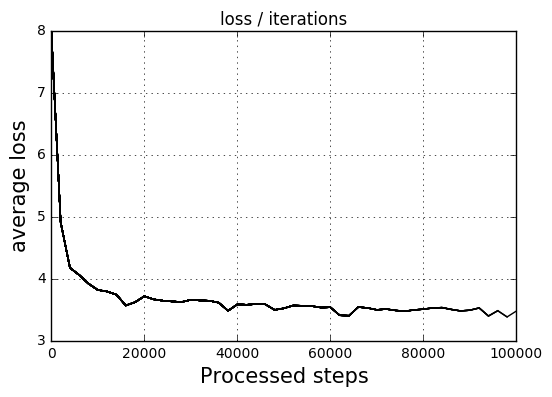

In [8]:
# Step 5: Start training.

num_steps = 100001

## display progress
import IPython.display as display
XX = []
YY = []


with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print "Initialized"
    log = None
    average_loss = 0
    for step in xrange(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print "Average loss at step", step, ":", average_loss
            print log
            # display loss progress
            YY.append(average_loss)
            XX.append(step)
            plt.plot(XX, YY, 'black')
            plt.ylabel('average loss', fontsize=15)
            plt.xlabel('Processed steps', fontsize=15)
            plt.title('', fontsize=20)
            plt.grid('on')
            plt.title('loss / iterations')
            plt.savefig("out.png")
            display.display(display.Image(filename="out.png"))
            display.clear_output(wait=True)
            
            # display Nearest neighbors
            # Note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in xrange(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = "Nearest to %s:" % valid_word
                    for k in xrange(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log = "%s %s," % (log, close_word)
            
            average_loss = 0
    final_embeddings = normalized_embeddings.eval()
print "DONE"

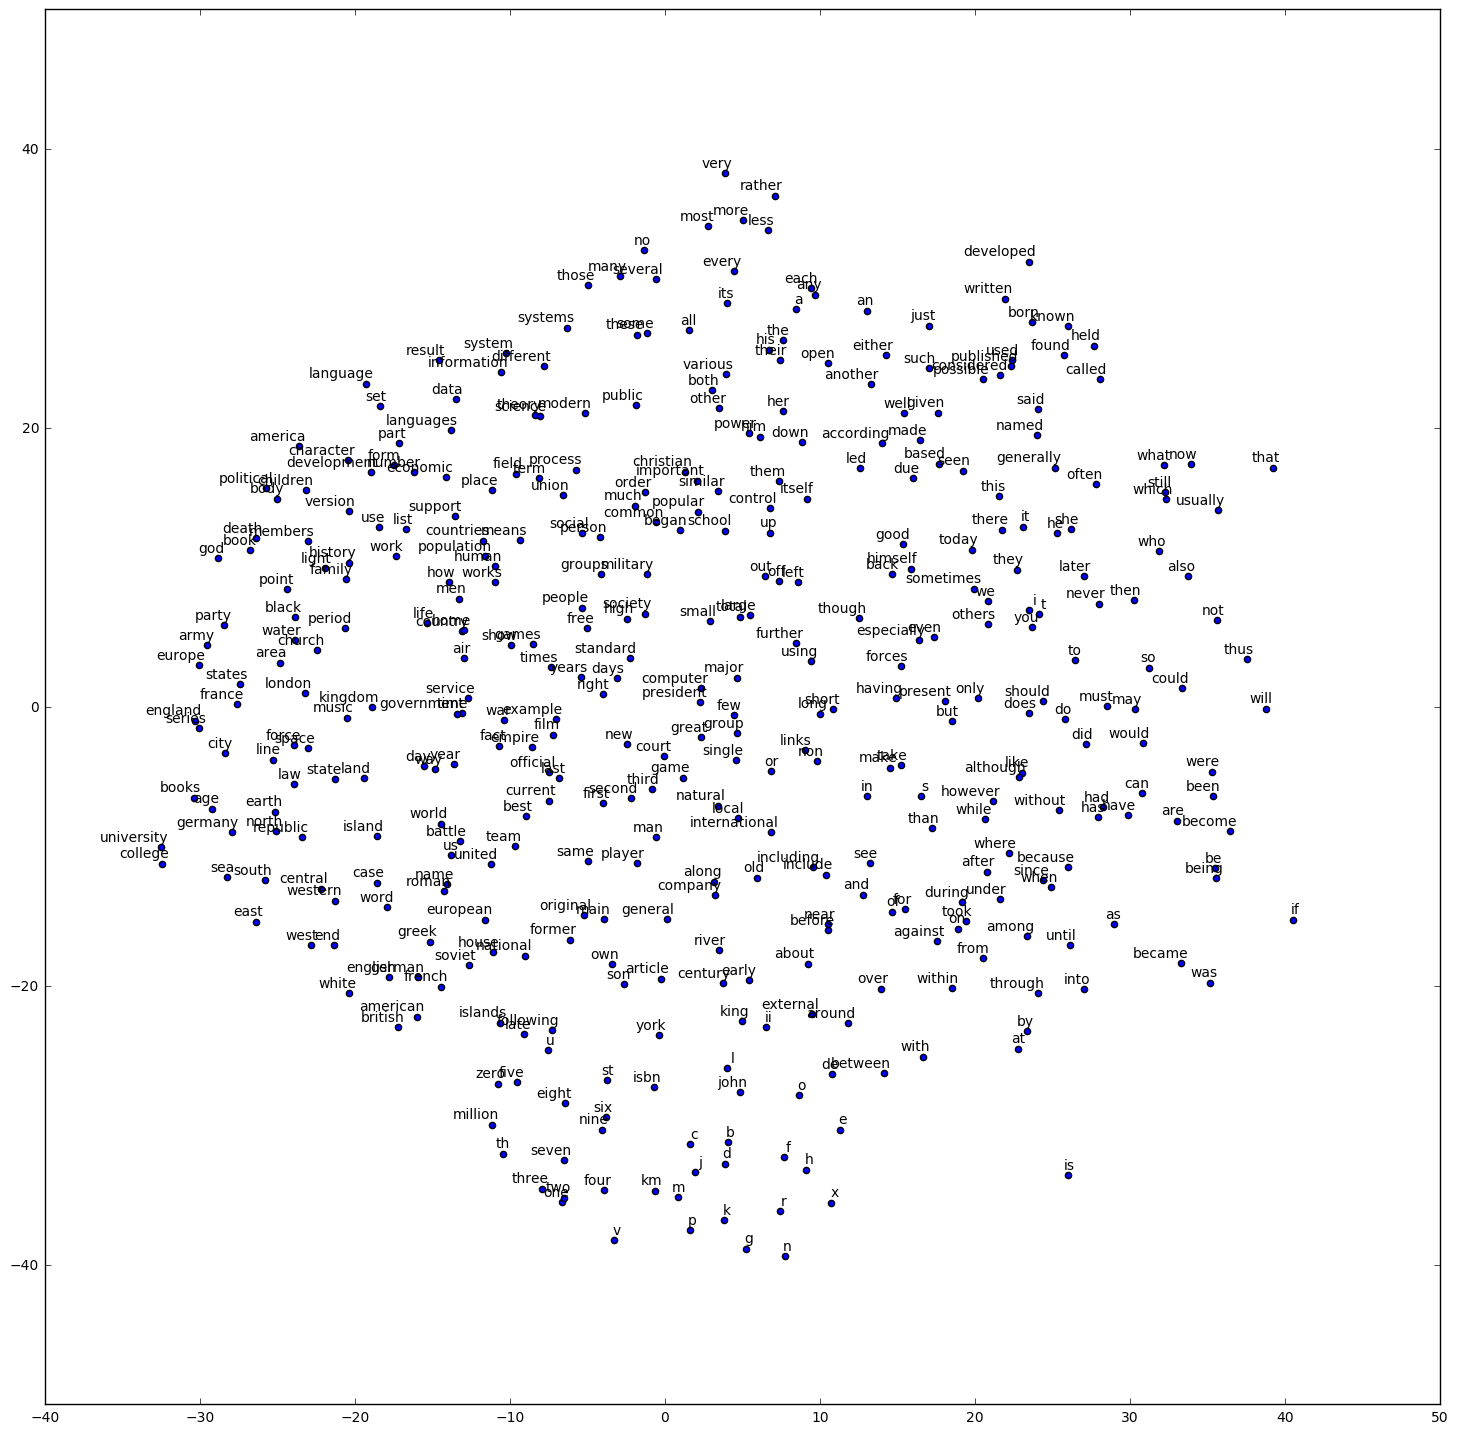

In [9]:
# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.savefig(filename)

num_points = 400   # Number of words to visualize.

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)  # Dimensionality reduction.
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
words = [reverse_dictionary[i] for i in xrange(1, num_points+1)]
plot_with_labels(two_d_embeddings, words)